In [1]:
import os, tqdm, json, pickle, gc, zipfile, itertools, time, collections
import pandas as pd
import numpy as np
from dateutil import parser
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

def get_responses(PATH_TO_RESPONSES):
    L_FILENAMES = os.listdir(PATH_TO_RESPONSES)
    L_RESPONSES = []
    for fnm in tqdm.tqdm(L_FILENAMES):
        try:
            pth = os.path.join(PATH_TO_RESPONSES, fnm)
            with open(pth, 'r') as f:
                d_rsp = json.load(f)
            L_RESPONSES.append(d_rsp)
        except:
            pass
    idx_ordered = np.argsort([d_game['id'] for d_game in L_RESPONSES])[::-1]
    L_RESPONSES = np.array(L_RESPONSES)[idx_ordered].tolist()
    return L_RESPONSES

def get_game_profile(L_RESPONSES):

    L_games = []

    L_PLAYER_STAT_KEYS = [
        'adr', 'assists', 'deaths', 'first_kills_diff', 'flash_assists', 
        'headshots', 'k_d_diff', 'kast', 'kills', 'rating'
    ]

    for rsp in tqdm.tqdm(L_RESPONSES):
        
        try:

            d = {}
            d['id'] = rsp['id']

            date = parser.parse(rsp['begin_at'])
            d['timestamp'] = date.timestamp()
            d['year'] = date.year
            d['month'] = date.month
            d['day'] = date.day
            d['weekday'] = date.weekday()
            d['hour'] = date.hour

            d['map__id'] = rsp['map']['id']

            d['league__id'] = rsp['match']['league']['id']
            d['serie__id'] = rsp['match']['serie']['id']
            d['tournament__id'] = rsp['match']['tournament']['id']
            try:
                d['serie__tier'] = str.lower(rsp['match']['serie']['tier']).strip()
            except:
                d['serie__tier'] = 'default'
            d['tournament__name'] = str.lower(rsp['match']['tournament']['name']).strip()
            pp = rsp['match']['tournament']['prizepool']
            try:
                d['tournament__prizepool_currency'] = str.lower(''.join(pp.split(' ')[1:]))
                d['tournament__prizepool_size'] = int(pp.split(' ')[0])
            except:
                d['tournament__prizepool_currency'] = 'default'
                d['tournament__prizepool_size'] = 0

            df_rounds = pd.DataFrame.from_records(rsp['rounds'])            

            r1_winner_id = df_rounds.query('round==1')['winner_team'].iloc[0]
            r2_winner_id = df_rounds.query('round==2')['winner_team'].iloc[0]
            r16_winner_id = df_rounds.query('round==16')['winner_team'].iloc[0]
            r17_winner_id = df_rounds.query('round==17')['winner_team'].iloc[0]
            d_h1_win_count = df_rounds.query('round<=15')['winner_team'].value_counts().to_dict()
            d_h2_win_count = df_rounds.query('round>15')['winner_team'].value_counts().to_dict()
            d_h1_outcome_count = df_rounds.query('round<=15')['outcome'].value_counts().to_dict()
            d_h2_outcome_count = df_rounds.query('round>15')['outcome'].value_counts().to_dict()


            d['team1__id'] =  df_rounds.query('round==1')['ct'].iloc[0]
            d['team2__id'] =  df_rounds.query('round==1')['terrorists'].iloc[0]

            d['team1__win'] = int(df_rounds['winner_team'].value_counts().idxmax() == d['team1__id'])
            d['team1__r1_win'] = 1 if r1_winner_id==d['team1__id'] else 0
            d['team1__r2_win'] = 1 if r2_winner_id==d['team1__id'] else 0
            d['team1__r16_win'] = 1 if r16_winner_id==d['team1__id'] else 0
            d['team1__r17_win'] = 1 if r17_winner_id==d['team1__id'] else 0
            d['team1__h1_win_count'] = d_h1_win_count[d['team1__id']] if d['team1__id'] in d_h1_win_count.keys() else 0
            d['team1__h2_win_count'] = d_h2_win_count[d['team1__id']] if d['team1__id'] in d_h2_win_count.keys() else 0
            for k, v in d_h1_outcome_count.items():
                d[f'team1__h1_{k}_count'] = v
            for k, v in d_h2_outcome_count.items():
                d[f'team1__h2_{k}_count'] = v
            
            d['team2__win'] = int(df_rounds['winner_team'].value_counts().idxmax() == d['team2__id'])  
            d['team2__r1_win'] = 1 if r1_winner_id==d['team2__id'] else 0
            d['team2__r2_win'] = 1 if r2_winner_id==d['team2__id'] else 0
            d['team2__r16_win'] = 1 if r16_winner_id==d['team2__id'] else 0
            d['team2__r17_win'] = 1 if r17_winner_id==d['team2__id'] else 0
            d['team2__h1_win_count'] = d_h1_win_count[d['team2__id']] if d['team2__id'] in d_h1_win_count.keys() else 0
            d['team2__h2_win_count'] = d_h2_win_count[d['team2__id']] if d['team2__id'] in d_h2_win_count.keys() else 0
            for k, v in d_h1_outcome_count.items():
                d[f'team2__h1_{k}_count'] = v
            for k, v in d_h2_outcome_count.items():
                d[f'team2__h2_{k}_count'] = v
            
            
            if len(rsp['players'])==10:
                counter4team1, counter4team2 = 1, 6
                for p in rsp['players']:
                    
                    team_id = p['team']['id']

                    if team_id == d['team1__id']: 
                        
                        d[f'player{counter4team1}__id'] = p['player']['id']
                        try:
                            d[f'player{counter4team1}__age'] = int(p['player']['age'])
                        except:
                            d[f'player{counter4team1}__age'] = -999
                        try:
                            d[f'player{counter4team1}__hometown'] = str.lower(p['player']['hometown']).strip()
                        except:
                            d[f'player{counter4team1}__hometown'] = 'default'
                        try:
                            d[f'player{counter4team1}__nationality'] = str.lower(p['player']['nationality']).strip()
                        except:
                            d[f'player{counter4team1}__nationality'] = 'default'
                        try:
                            d['team1__location'] = str.lower(p['team']['location']).strip()
                        except:
                            d['team1__location'] = 'default'

                        for key in L_PLAYER_STAT_KEYS:
                            value = p[key]
                            d[f'player{counter4team1}__{key}'] = value if pd.notnull(value) else 0.0

                        counter4team1+=1

                    else:

                        d[f'player{counter4team2}__id'] = p['player']['id']
                        try:
                            d[f'player{counter4team2}__age'] = int(p['player']['age'])
                        except:
                            d[f'player{counter4team2}__age'] = -999
                        try:
                            d[f'player{counter4team2}__hometown'] = str.lower(p['player']['hometown']).strip()
                        except:
                            d[f'player{counter4team2}__hometown'] = 'default'
                        try:
                            d[f'player{counter4team2}__nationality'] = str.lower(p['player']['nationality']).strip()
                        except:
                            d[f'player{counter4team2}__nationality'] = 'default'
                        try:
                            d['team2__location'] = str.lower(p['team']['location']).strip()
                        except:
                            d['team2__location'] = 'default'

                        for key in L_PLAYER_STAT_KEYS:
                            value = p[key]
                            d[f'player{counter4team2}__{key}'] = value if pd.notnull(value) else 0.0

                        counter4team2+=1

                ser = pd.Series(d)

                for key in L_PLAYER_STAT_KEYS:
                    m1 = ser.index.str.contains('player1_|player2_|player3_|player4_|player5_')
                    m2 = ser.index.str.contains(key)
                    ser.loc[f'team1__{key}'] = ser.loc[m1&m2].mean()
                for key in L_PLAYER_STAT_KEYS:
                    m1 = ser.index.str.contains('player6_|player7_|player8_|player9_|player10_')
                    m2 = ser.index.str.contains(key)
                    ser.loc[f'team2__{key}'] = ser.loc[m1&m2].mean()

                cs4p = []
                for i in range(1, 11):
                    cs4p.extend(ser.index[ser.index.str.contains(f'player{i}__')].tolist())
                cs4t = []
                for i in [1, 2]:
                    cs4t.extend(ser.index[ser.index.str.contains(f'team{i}__')].tolist())
                d = pd.concat([ser.drop(cs4p+cs4t), ser[cs4t], ser[cs4p]]).to_dict()

                L_games.append(d)            
            
        except:
            pass

    df_games = pd.DataFrame.from_records(L_games).sort_values('timestamp').reset_index(drop = True)
    del L_games
    gc.collect()

    L_PLAYER_STAT_KEYS = [
        'adr', 'assists', 'deaths', 'first_kills_diff', 'flash_assists', 
        'headshots', 'k_d_diff', 'kast', 'kills', 'rating'
    ]

    for key in L_PLAYER_STAT_KEYS:
        fs = df_games.columns[df_games.columns.str.contains(key)]
        df_games[fs] = df_games[fs].fillna(0.0)

    L_TEAM_STAT_KEYS = [
        
        'team1__h1_eliminated_count', 'team1__h1_defused_count',
        'team1__h1_exploded_count', 'team1__h1_timeout_count',
        'team1__h2_eliminated_count', 'team1__h2_defused_count',
        'team1__h2_exploded_count', 'team1__h2_timeout_count',

        'team2__h1_eliminated_count', 'team2__h1_defused_count',
        'team2__h1_exploded_count', 'team2__h1_timeout_count',
        'team2__h2_eliminated_count', 'team2__h2_defused_count',
        'team2__h2_exploded_count', 'team2__h2_timeout_count'
    ]
    df_games[L_TEAM_STAT_KEYS] = df_games[L_TEAM_STAT_KEYS].fillna(0.0)

    team_keys = df_games.columns[df_games.columns.str.contains('team1')].tolist()+\
            df_games.columns[df_games.columns.str.contains('team2')].tolist()
    player_keys = []
    for i in range(1, 11):
        player_keys.extend(df_games.columns[df_games.columns.str.contains(f'player{i}__')].tolist())      

    df_games = pd.concat([df_games.drop(team_keys+player_keys, 1), df_games[team_keys], df_games[player_keys]], 1)
    df_games = df_games.dropna(subset = ['team1__id', 'team2__id']).reset_index(drop = True)    
        
    return df_games

In [2]:
# # директория с респонсами
# PATH_TO_RESPONSES = 'responses'

# L_RESPONSES = get_responses(PATH_TO_RESPONSES)
# with open('L_RESPONSES.pickle','wb') as f:
#     pickle.dump(L_RESPONSES)
with open('L_RESPONSES.pickle','rb') as f:
    L_RESPONSES = pickle.load(f)

In [2]:
# таблица с профайлингом команд и игроков в играх
# df_game_profile = get_game_profile(L_RESPONSES)
# df_game_profile.to_pickle('df_game_profile_18052022.pickle')
df_game_profile = pd.read_pickle('df_game_profile_18052022.pickle')

In [3]:

df_game_profile.head()

,id,timestamp,year,month,day,weekday,hour,map__id,league__id,serie__id,...,player10__adr,player10__assists,player10__deaths,player10__first_kills_diff,player10__flash_assists,player10__headshots,player10__k_d_diff,player10__kast,player10__kills,player10__rating
0,1396,1.452687e+09,2016,1,13,2,12,1,4164,1593,...,120.1,3.0,13,-1.0,0.0,13.0,10.0,85.7,23,1.79
1,1397,1.452690e+09,2016,1,13,2,12,3,4164,1593,...,76.9,1.0,18,0.0,0.0,11.0,-1.0,52.2,17,0.98
2,1393,1.452696e+09,2016,1,13,2,14,3,4164,1593,...,77.6,4.0,22,1.0,0.0,5.0,-10.0,56.0,12,0.70
3,1394,1.452699e+09,2016,1,13,2,15,2,4164,1593,...,113.1,6.0,16,5.0,0.0,14.0,9.0,82.6,25,1.76
4,1387,1.452704e+09,2016,1,13,2,17,2,4164,1593,...,81.3,2.0,14,0.0,0.0,6.0,3.0,77.3,17,1.24


In [4]:
assert df_game_profile.isna().any().any() == False

In [5]:
# сплит
TEST_SIZE = .1

df_game_profile = pd.read_pickle('df_game_profile_18052022.pickle')
df_game_profile_train, df_game_profile_test = train_test_split(df_game_profile, test_size = TEST_SIZE, shuffle = False)
del df_game_profile
gc.collect()

30

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class InRangeScaler(BaseEstimator, TransformerMixin):

    def __init__(self, out_range):
        self.out_range = out_range        
    
    def fit(self, X_tr, y_tr = None):
        assert isinstance(X_tr, pd.Series)
        self.domain = np.min(X_tr), np.max(X_tr)
        return self

    def transform(self, X_tr):
        y = (X_tr - (self.domain[1] + self.domain[0]) / 2) / (self.domain[1] - self.domain[0])
        return y * (self.out_range[1] - self.out_range[0]) + (self.out_range[1] + self.out_range[0]) / 2

In [7]:
rng_scaler = InRangeScaler(out_range = (.1, .9))
rng_scaler.fit(df_game_profile_train['timestamp'])

df_game_profile_train['timestamp'] = rng_scaler.transform(df_game_profile_train['timestamp'])
df_game_profile_test['timestamp'] = rng_scaler.transform(df_game_profile_test['timestamp'])

In [8]:
df_game_profile_train['tournament__prizepool_size']//=1000
df_game_profile_test['tournament__prizepool_size']//=1000

In [9]:
FILL_VALUE=-999

In [10]:
df_game_profile_train['team1__id']

0          3284.0
1          3216.0
2          3228.0
3          3210.0
4          3210.0
           ...   
35212    129413.0
35213    126944.0
35214    126288.0
35215     60201.0
35216      3394.0
Name: team1__id, Length: 35217, dtype: float64

In [11]:
from sklearn.preprocessing import LabelEncoder

to_encode = ['year', 'month', 'day', 'weekday', 'hour', 'map__id',
 'league__id', 'serie__id', 'tournament__id', 'serie__tier',
 'tournament__name', 'tournament__prizepool_currency',
 'tournament__prizepool_size'
 ]

for key in to_encode:    
    
    tr_ser = df_game_profile_train[key]
    uniques = np.unique(tr_ser)
    labels = np.arange(len(uniques))  
    d =dict(zip(uniques,labels))  
    
    df_game_profile_train[key] = df_game_profile_train[key].apply(lambda x: d[x] if x in d.keys() else FILL_VALUE)
    df_game_profile_test[key] = df_game_profile_test[key].apply(lambda x: d[x] if x in d.keys() else FILL_VALUE)


In [12]:
team_id_keys = ['team1__id', 'team2__id']

uniques = np.unique(df_game_profile_train[team_id_keys].values.flatten())
labels = np.arange(len(uniques))  
d =dict(zip(uniques,labels))  

df_game_profile_train[team_id_keys]= df_game_profile_train[team_id_keys].applymap(lambda x: d[x] if x in d.keys()else FILL_VALUE)
df_game_profile_test[team_id_keys]= df_game_profile_test[team_id_keys].applymap(lambda x: d[x] if x in d.keys()else FILL_VALUE)

In [13]:
player_id_keys = [
    'player1__id', 'player2__id', 'player3__id', 'player4__id', 'player5__id',
    'player6__id', 'player7__id', 'player8__id', 'player9__id', 'player10__id'
]

uniques = np.unique(df_game_profile_train[player_id_keys].values.flatten())
labels = np.arange(len(uniques))  
d =dict(zip(uniques,labels))  

df_game_profile_train[player_id_keys]= df_game_profile_train[player_id_keys].applymap(lambda x: d[x] if x in d.keys() else FILL_VALUE)
df_game_profile_test[player_id_keys]= df_game_profile_test[player_id_keys].applymap(lambda x: d[x] if x in d.keys() else FILL_VALUE)

In [14]:
team_loc_keys = [
    'team1__location', 'team2__location'
]

uniques = np.unique(df_game_profile_train[team_loc_keys].values.flatten())
labels = np.arange(len(uniques))  
d =dict(zip(uniques,labels))  

df_game_profile_train[team_loc_keys]= df_game_profile_train[team_loc_keys].applymap(lambda x: d[x] if x in d.keys() else FILL_VALUE)
df_game_profile_test[team_loc_keys]= df_game_profile_test[team_loc_keys].applymap(lambda x: d[x] if x in d.keys() else FILL_VALUE)

In [15]:
p_ht_nat_keys = [
    'player1__hometown', 'player2__hometown', 'player3__hometown', 'player4__hometown',
    'player5__hometown', 'player6__hometown', 'player7__hometown', 'player8__hometown',
    'player9__hometown', 'player10__hometown',

    'player1__nationality', 'player2__nationality', 'player3__nationality', 'player4__nationality',
    'player5__nationality', 'player6__nationality', 'player7__nationality', 'player8__nationality',
    'player9__nationality', 'player10__nationality',
]

uniques = np.unique(df_game_profile_train[p_ht_nat_keys].values.flatten())
labels = np.arange(len(uniques))  
d =dict(zip(uniques,labels))  

df_game_profile_train[p_ht_nat_keys]= df_game_profile_train[p_ht_nat_keys].applymap(lambda x: d[x] if x in d.keys() else FILL_VALUE)
df_game_profile_test[p_ht_nat_keys]= df_game_profile_test[p_ht_nat_keys].applymap(lambda x: d[x] if x in d.keys() else FILL_VALUE)


In [270]:
df_game_profile_train.columns

,id,timestamp,year,month,day,weekday,hour,map__id,league__id,serie__id,...,player4__age_v2,player5__age_v2,player6__age_v2,player7__age_v2,player8__age_v2,player9__age_v2,player10__age_v2,timestamp_v1,timestamp_v2,timestamp_v3
0,1396,0.100000,0,0,12,2,12,0,10,38,...,1,3,0,7,4,5,4,0.1,0.1,0.1
1,1397,0.100011,0,0,12,2,12,2,10,38,...,5,4,9,8,7,1,3,0.1,0.1,0.1
2,1393,0.100039,0,0,12,2,14,2,10,38,...,7,2,5,7,0,5,8,0.1,0.1,0.1
3,1394,0.100052,0,0,12,2,15,1,10,38,...,5,8,0,0,7,7,2,0.1,0.1,0.1
4,1387,0.100073,0,0,12,2,17,1,10,38,...,5,8,9,8,7,1,3,0.1,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35212,64139,0.899962,6,0,25,2,9,7,232,996,...,2,9,6,2,3,9,1,0.9,0.9,0.9
35213,64143,0.899976,6,0,25,2,10,6,232,996,...,8,0,6,6,3,8,7,0.9,0.9,0.9
35214,64140,0.899976,6,0,25,2,10,0,232,996,...,0,5,1,4,1,9,9,0.9,0.9,0.9
35215,63340,0.899992,6,0,25,2,12,7,108,998,...,9,0,5,4,2,4,2,0.9,0.9,0.9


In [16]:
L_p_age_keys =[
    'player1__age', 'player2__age', 'player3__age', 'player4__age',
    'player5__age', 'player6__age', 'player7__age', 'player8__age',
    'player9__age', 'player10__age'
]

df_age_train =pd.concat([(df_game_profile_train[L_p_age_keys]//10).add_suffix('_v1'),\
                    (df_game_profile_train[L_p_age_keys]%10).add_suffix('_v2')],1)
df_age_test =pd.concat([(df_game_profile_test[L_p_age_keys]//10).add_suffix('_v1'),\
                    (df_game_profile_test[L_p_age_keys]%10).add_suffix('_v2')],1)

L_age_v1_keys= [
    'player1__age_v1', 'player2__age_v1', 'player3__age_v1',
    'player4__age_v1', 'player5__age_v1', 'player6__age_v1',
    'player7__age_v1', 'player8__age_v1', 'player9__age_v1',
    'player10__age_v1'
]

uniques = np.unique(df_age_train[L_age_v1_keys].values.flatten())
labels = np.arange(len(uniques))  
d =dict(zip(uniques,labels))  

df_age_train[L_age_v1_keys]= df_age_train[L_age_v1_keys].applymap(lambda x: d[x] if x in d.keys() else FILL_VALUE)
df_age_test[L_age_v1_keys]= df_age_test[L_age_v1_keys].applymap(lambda x: d[x] if x in d.keys() else FILL_VALUE)


L_age_v2_keys= [
    'player1__age_v2', 'player2__age_v2',
    'player3__age_v2', 'player4__age_v2', 'player5__age_v2',
    'player6__age_v2', 'player7__age_v2', 'player8__age_v2',
    'player9__age_v2', 'player10__age_v2'
]

uniques = np.unique(df_age_train[L_age_v2_keys].values.flatten())
labels = np.arange(len(uniques))  
d =dict(zip(uniques,labels))  

df_age_train[L_age_v2_keys]= df_age_train[L_age_v2_keys].applymap(lambda x: d[x] if x in d.keys() else FILL_VALUE)
df_age_test[L_age_v2_keys]= df_age_test[L_age_v2_keys].applymap(lambda x: d[x] if x in d.keys() else FILL_VALUE)

In [17]:
df_game_profile_train.drop(L_p_age_keys,1,inplace= True)
df_game_profile_test.drop(L_p_age_keys,1,inplace= True)

df_game_profile_train =pd.concat([df_game_profile_train, df_age_train],1)
df_game_profile_test =pd.concat([df_game_profile_test, df_age_test],1)

In [18]:
df_game_profile_train.head()

,id,timestamp,year,month,day,weekday,hour,map__id,league__id,serie__id,...,player1__age_v2,player2__age_v2,player3__age_v2,player4__age_v2,player5__age_v2,player6__age_v2,player7__age_v2,player8__age_v2,player9__age_v2,player10__age_v2
0,1396,0.100000,0,0,12,2,12,0,10,38,...,9,8,7,1,3,0,7,4,5,4
1,1397,0.100011,0,0,12,2,12,2,10,38,...,0,7,4,5,4,9,8,7,1,3
2,1393,0.100039,0,0,12,2,14,2,10,38,...,0,0,7,7,2,5,7,0,5,8
3,1394,0.100052,0,0,12,2,15,1,10,38,...,5,7,0,5,8,0,0,7,7,2
4,1387,0.100073,0,0,12,2,17,1,10,38,...,5,7,0,5,8,9,8,7,1,3


In [19]:
df_game_profile_test.head()

,id,timestamp,year,month,day,weekday,hour,map__id,league__id,serie__id,...,player1__age_v2,player2__age_v2,player3__age_v2,player4__age_v2,player5__age_v2,player6__age_v2,player7__age_v2,player8__age_v2,player9__age_v2,player10__age_v2
35217,64141,0.900001,6,0,25,2,12,1,232,996,...,1,4,1,9,9,0,1,2,0,5
35218,63341,0.900007,6,0,25,2,13,5,108,998,...,5,4,2,4,2,3,3,1,9,0
35219,64145,0.900015,6,0,25,2,13,7,232,996,...,6,6,3,8,7,5,2,4,8,0
35220,64142,0.900018,6,0,25,2,13,7,232,996,...,1,4,1,9,9,0,1,2,0,5
35221,63342,0.900023,6,0,25,2,14,1,108,998,...,5,4,2,4,2,3,3,1,9,0


In [20]:
L_PLAYER_STAT_KEYS = [
    'adr', 'assists', 'deaths', 'first_kills_diff', 'flash_assists', 
    'headshots', 'k_d_diff', 'kast', 'kills', 'rating'
]
    

L_TEAM_STAT_KEYS = [
    'h1_eliminated_count', 'h1_defused_count',
    'h1_exploded_count', 'h1_timeout_count',
    'h2_eliminated_count', 'h2_defused_count',
    'h2_exploded_count', 'h2_timeout_count',

    
]

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()

for key in L_PLAYER_STAT_KEYS:

    cs = df_game_profile_train.columns[df_game_profile_train.columns.str.contains(key)]
    n1= len(cs)
    arr_tr= df_game_profile_train[cs].values.flatten()
    arr_te= df_game_profile_test[cs].values.flatten()
    
    scaler.fit(df_game_profile_train[cs].values.flatten().reshape(int(len(arr_tr)/n1),n1))
    df_game_profile_train[cs] = scaler.transform(df_game_profile_train[cs].values.flatten().reshape(int(len(arr_tr)/n1),n1))
    df_game_profile_test[cs] = scaler.transform(df_game_profile_test[cs].values.flatten().reshape(int(len(arr_te)/n1),n1))

for key in L_TEAM_STAT_KEYS:

    cs = df_game_profile_train.columns[df_game_profile_train.columns.str.contains(key)]
    n1= len(cs)
    arr_tr= df_game_profile_train[cs].values.flatten()
    arr_te= df_game_profile_test[cs].values.flatten()
    
    scaler.fit(df_game_profile_train[cs].values.flatten().reshape(int(len(arr_tr)/n1),n1))
    df_game_profile_train[cs] = scaler.transform(df_game_profile_train[cs].values.flatten().reshape(int(len(arr_tr)/n1),n1))
    df_game_profile_test[cs] = scaler.transform(df_game_profile_test[cs].values.flatten().reshape(int(len(arr_te)/n1),n1))

In [22]:
assert df_game_profile_train.notna().all().all()
assert df_game_profile_test.notna().all().all()

In [23]:
df_game_profile_train.head()

,id,timestamp,year,month,day,weekday,hour,map__id,league__id,serie__id,...,player1__age_v2,player2__age_v2,player3__age_v2,player4__age_v2,player5__age_v2,player6__age_v2,player7__age_v2,player8__age_v2,player9__age_v2,player10__age_v2
0,1396,0.100000,0,0,12,2,12,0,10,38,...,9,8,7,1,3,0,7,4,5,4
1,1397,0.100011,0,0,12,2,12,2,10,38,...,0,7,4,5,4,9,8,7,1,3
2,1393,0.100039,0,0,12,2,14,2,10,38,...,0,0,7,7,2,5,7,0,5,8
3,1394,0.100052,0,0,12,2,15,1,10,38,...,5,7,0,5,8,0,0,7,7,2
4,1387,0.100073,0,0,12,2,17,1,10,38,...,5,7,0,5,8,9,8,7,1,3


In [24]:
df_game_profile_train.columns[df_game_profile_train.columns.str.contains('id')]

Index(['id', 'map__id', 'league__id', 'serie__id', 'tournament__id',
       'team1__id', 'team2__id', 'player1__id', 'player2__id', 'player3__id',
       'player4__id', 'player5__id', 'player6__id', 'player7__id',
       'player8__id', 'player9__id', 'player10__id'],
      dtype='object')

In [25]:
df_game_profile_train.columns[:20]

Index(['id', 'timestamp', 'year', 'month', 'day', 'weekday', 'hour', 'map__id',
       'league__id', 'serie__id', 'tournament__id', 'serie__tier',
       'tournament__name', 'tournament__prizepool_currency',
       'tournament__prizepool_size', 'team1__id', 'team1__win',
       'team1__r1_win', 'team1__r2_win', 'team1__r16_win'],
      dtype='object')

In [26]:
cat_keys_v1=['year', 'month', 'day', 'weekday', 'hour', 'map__id',
       'league__id', 'serie__id', 'tournament__id', 'serie__tier',
       'tournament__name', 'tournament__prizepool_currency',
       'tournament__prizepool_size', 'team1__id', 'team2__id']
cat_keys_v2=['player1__id', 'player2__id', 'player3__id',
       'player4__id', 'player5__id', 'player6__id', 'player7__id',
       'player8__id', 'player9__id', 'player10__id']

cat_keys4tm1= ['player1__id', 'player2__id', 'player3__id', 'player4__id', 'player5__id']
cat_keys4tm2= ['player6__id', 'player7__id', 'player8__id', 'player9__id', 'player10__id']

cat_keys_v3 =['team1__location', 'team2__location', 'player1__hometown', 'player2__hometown', 'player3__hometown', 'player4__hometown',
    'player5__hometown', 'player6__hometown', 'player7__hometown', 'player8__hometown',
    'player9__hometown', 'player10__hometown',

    'player1__nationality', 'player2__nationality', 'player3__nationality', 'player4__nationality',
    'player5__nationality', 'player6__nationality', 'player7__nationality', 'player8__nationality',
    'player9__nationality', 'player10__nationality',
    'player1__age_v1', 'player2__age_v1', 'player3__age_v1',
    'player4__age_v1', 'player5__age_v1', 'player6__age_v1',
    'player7__age_v1', 'player8__age_v1', 'player9__age_v1',
    'player10__age_v1', 'player1__age_v2', 'player2__age_v2',
    'player3__age_v2', 'player4__age_v2', 'player5__age_v2',
    'player6__age_v2', 'player7__age_v2', 'player8__age_v2',
    'player9__age_v2', 'player10__age_v2']

df_game_profile_train[cat_keys_v1] = df_game_profile_train[cat_keys_v1].astype('category')
df_game_profile_test[cat_keys_v1] = df_game_profile_test[cat_keys_v1].astype('category')

df_game_profile_train[cat_keys_v2] = df_game_profile_train[cat_keys_v2].astype('str')
df_game_profile_test[cat_keys_v2] = df_game_profile_test[cat_keys_v2].astype('str')

In [27]:
L_df_p_combo_train =[]
for i, ps in enumerate(list(itertools.permutations(cat_keys4tm1, 5))):
    ps= list(ps)
    df = df_game_profile_train[ps]
    df.columns= cat_keys4tm1
    df = df.add_suffix(f'_v{i+1}')
    L_df_p_combo_train.append(df)
    del df

for i, ps in enumerate(list(itertools.permutations(cat_keys4tm2, 5))):
    ps= list(ps)
    df = df_game_profile_train[ps]
    df.columns= cat_keys4tm1
    df = df.add_suffix(f'_v{i+1}')
    L_df_p_combo_train.append(df)
    del df

L_df_p_combo_test =[]
for i, ps in enumerate(list(itertools.permutations(cat_keys4tm1, 5))):
    ps= list(ps)
    df = df_game_profile_test[ps]
    df.columns= cat_keys4tm2
    df = df.add_suffix(f'_v{i+1}')
    L_df_p_combo_test.append(df)
    del df

for i, ps in enumerate(list(itertools.permutations(cat_keys4tm2, 5))):
    ps= list(ps)
    df = df_game_profile_test[ps]
    df.columns= cat_keys4tm2
    df = df.add_suffix(f'_v{i+1}')
    L_df_p_combo_test.append(df)
    del df


In [124]:
# df_game_profile_train['timestamp_v1'] = df_game_profile_train['timestamp'].round(1).astype('category')
# df_game_profile_train['timestamp_v2'] = df_game_profile_train['timestamp'].round(2).astype('category')
# df_game_profile_train['timestamp_v3'] = df_game_profile_train['timestamp'].round(3).astype('category')

# df_game_profile_test['timestamp_v1'] = df_game_profile_test['timestamp'].round(1).astype('category')
# df_game_profile_test['timestamp_v2'] = df_game_profile_test['timestamp'].round(2).astype('category')
# df_game_profile_test['timestamp_v3'] = df_game_profile_test['timestamp'].round(3).astype('category')

# cat_keys_v0 = ['timestamp_v1','timestamp_v2', 'timestamp_v3']

df1_train = pd.concat([ df_game_profile_train['id'], 
df_game_profile_train[cat_keys_v0].astype('category'),
  df_game_profile_train[cat_keys_v1].astype('category'),
 df_game_profile_train[cat_keys_v2].astype('category'),
 df_game_profile_train[cat_keys_v3].astype('category'),
  pd.concat(L_df_p_combo_train, 1).astype('category')], 1)

df1_test = pd.concat([ df_game_profile_test['id'], 
 df_game_profile_test[cat_keys_v0].astype('category'),
  df_game_profile_test[cat_keys_v1].astype('category'),
 df_game_profile_test[cat_keys_v2].astype('category'),
 df_game_profile_test[cat_keys_v3].astype('category'),
  pd.concat(L_df_p_combo_test, 1).astype('category')], 1)

In [29]:
L_keys4team_with_info = [
       'id', 'timestamp', 'year', 'month', 'day', 'weekday', 'hour', 'map__id',
       'league__id', 'serie__id', 'tournament__id', 'serie__tier',  
       'team1__id', 'team2__id'
]

L_ks4tm1 = [
    
    'team1__win', 'team1__r1_win', 'team1__r2_win',
       'team1__r16_win', 'team1__r17_win', 'team1__h1_win_count',
       'team1__h2_win_count', 'team1__h1_eliminated_count',
       'team1__h1_defused_count', 'team1__h1_exploded_count',
       'team1__h2_eliminated_count', 'team1__h2_defused_count',
       'team1__h2_exploded_count',

    'team1__adr', 'team1__assists', 'team1__deaths',
       'team1__first_kills_diff', 'team1__flash_assists', 'team1__headshots',
       'team1__k_d_diff', 'team1__kast', 'team1__kills', 'team1__rating']

L_ks4tm2 = [
    
    'team2__win', 'team2__r1_win', 'team2__r2_win',
       'team2__r16_win', 'team2__r17_win', 'team2__h1_win_count',
       'team2__h2_win_count', 'team2__h1_eliminated_count',
       'team2__h1_defused_count', 'team2__h1_exploded_count',
       'team2__h2_eliminated_count', 'team2__h2_defused_count',
       'team2__h2_exploded_count',

    'team2__adr', 'team2__assists', 'team2__deaths',
       'team2__first_kills_diff', 'team2__flash_assists', 'team2__headshots',
       'team2__k_d_diff', 'team2__kast', 'team2__kills', 'team2__rating']

filter_keys = ['year', 'month', 'day', 'weekday', 'hour', 'map__id',
       'league__id', 'serie__id', 'tournament__id', 'serie__tier']

d_ks4tm = {0:L_ks4tm1, 1:L_ks4tm2}

new_ks = ['timestamp','opponent_id', 'year', 'month', 'day', 'weekday', 'hour', 'map__id',
       'league__id', 'serie__id', 'tournament__id', 'serie__tier',  'win',
 'r1_win',
 'r2_win',
 'r16_win',
 'r17_win',
 'h1_win_count',
 'h2_win_count',
 'h1_eliminated_count',
 'h1_defused_count',
 'h1_exploded_count',
 'h2_eliminated_count',
 'h2_defused_count',
 'h2_exploded_count',
 'adr',
 'assists',
 'deaths',
 'first_kills_diff',
 'flash_assists',
 'headshots',
 'k_d_diff',
 'kast',
 'kills',
 'rating', 'lineup']  

       
df2_game_profile_train =df_game_profile_train[L_keys4team_with_info+L_ks4tm1+L_ks4tm2]
df2_game_profile_test = df_game_profile_test[L_keys4team_with_info+L_ks4tm1+L_ks4tm2]

L_p4t1=['player1__id', 'player2__id', 'player3__id',
       'player4__id', 'player5__id']
L_p4t2=['player6__id', 'player7__id',
       'player8__id', 'player9__id', 'player10__id']

df2_game_profile_train['team1__lineup'] = df_game_profile_train[L_p4t1].apply(lambda x: '-'.join(x.sort_values().astype(str) ), axis = 1)
df2_game_profile_train['team2__lineup'] = df_game_profile_train[L_p4t2].apply(lambda x: '-'.join(x.sort_values().astype(str) ), axis = 1)
df2_game_profile_test['team1__lineup'] = df_game_profile_test[L_p4t1].apply(lambda x: '-'.join(x.sort_values().astype(str) ), axis = 1)
df2_game_profile_test['team2__lineup'] = df_game_profile_test[L_p4t2].apply(lambda x: '-'.join(x.sort_values().astype(str) ), axis = 1)

In [30]:
# 'lineup'
df2_game_profile_train

,id,timestamp,year,month,day,weekday,hour,map__id,league__id,serie__id,...,team2__deaths,team2__first_kills_diff,team2__flash_assists,team2__headshots,team2__k_d_diff,team2__kast,team2__kills,team2__rating,team1__lineup,team2__lineup
0,1396,0.100000,0,0,12,2,12,0,10,38,...,0.178439,0.600000,0.000000,0.338843,0.748201,0.819614,0.326531,0.805616,258-259-261-282-283,31-44-45-47-74
1,1397,0.100011,0,0,12,2,12,2,10,38,...,0.327138,0.466667,0.000000,0.314050,0.294964,0.567904,0.227891,0.453564,31-44-45-47-74,258-259-261-282-283
2,1393,0.100039,0,0,12,2,14,2,10,38,...,0.356877,0.333333,0.000000,0.305785,0.273381,0.622019,0.224490,0.451404,3-4-48-5-6,110-129-26-29-60
3,1394,0.100052,0,0,12,2,15,1,10,38,...,0.241636,0.555556,0.000000,0.355372,0.661871,0.838482,0.336735,0.737581,110-129-26-29-60,3-4-48-5-6
4,1387,0.100073,0,0,12,2,17,1,10,38,...,0.230483,0.444444,0.000000,0.314050,0.604317,0.829359,0.282313,0.697624,110-129-26-29-60,258-259-261-282-283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35212,64139,0.899962,6,0,25,2,9,7,232,996,...,0.349442,0.355556,0.444444,0.380165,0.316547,0.665354,0.241497,0.491361,152-154-194-2433-596,1244-2885-4027-4132-879
35213,64143,0.899976,6,0,25,2,10,6,232,996,...,0.475836,0.444444,0.222222,0.413223,0.338129,0.656438,0.380952,0.503240,1313-1327-1877-2689-47,114-1586-2444-2828-334
35214,64140,0.899976,6,0,25,2,10,0,232,996,...,0.501859,0.200000,0.194444,0.413223,0.345324,0.703089,0.370748,0.498920,1035-1038-1788-231-373,2442-2905-394-478-508
35215,63340,0.899992,6,0,25,2,12,7,108,998,...,0.234201,0.422222,0.333333,0.404959,0.589928,0.775451,0.275510,0.652268,1032-1728-1775-1879-477,1854-20-2542-2700-547


In [31]:
L_keys4team_with_info.extend(['team1__lineup', 'team2__lineup'])

In [32]:
L_ks4tm1.append('team1__lineup')
L_ks4tm2.append('team2__lineup')

In [33]:
def get_history(df2_game_profile_train, timestamp, team_id):

    all_keys = ['timestamp', 'year', 'month', 'day', 'weekday', 'hour', 'map__id',
       'league__id', 'serie__id', 'tournament__id', 'serie__tier',  'lineup', 'start_ct','opponent_id',  'win',
       'r1_win', 'r2_win', 'r16_win', 'r17_win', 'h1_win_count',
       'h2_win_count', 'h1_eliminated_count', 'h1_defused_count',
       'h1_exploded_count', 'h2_eliminated_count', 'h2_defused_count',
       'h2_exploded_count', 'adr', 'assists', 'deaths', 'first_kills_diff',
       'flash_assists', 'headshots', 'k_d_diff', 'kast', 'kills', 'rating',
      ]

    df_hist = df2_game_profile_train.query('(timestamp<@timestamp)')
    df1 = df_hist.query('team1__id==@team_id')[['timestamp', 'team2__id']+filter_keys+d_ks4tm[0]].rename(columns = {'team2__id':'opponent_id'})  
    df1.columns = new_ks
    df1['start_ct']=1
    df2 = df_hist.query('team2__id==@team_id')[['timestamp', 'team1__id']+filter_keys+d_ks4tm[1]].rename(columns = {'team1__id':'opponent_id'})  
    df2.columns = new_ks
    df2['start_ct']=0
    df = pd.concat([df1, df2]).sort_values('timestamp', ascending = False)
    del df1, df2, df_hist
    
    return df[all_keys].reset_index(drop = True)
    
L_AGG_KEYS = ['win', 'r1_win', 'r2_win', 'r16_win', 'r17_win', 'h1_win_count',
       'h2_win_count', 'h1_eliminated_count', 'h1_defused_count',
       'h1_exploded_count', 'h2_eliminated_count', 'h2_defused_count',
       'h2_exploded_count', 'adr', 'assists', 'deaths', 'first_kills_diff',
       'flash_assists', 'headshots', 'k_d_diff', 'kast', 'kills', 'rating']
L_GAME_IDXS = np.unique(df2_game_profile_train['id'])
L_INFO_KEYS = ['id', 'timestamp', 'year', 'month', 'day', 'weekday', 'hour', 'map__id', 'league__id', 'serie__id', 'tournament__id', 'serie__tier', 'team1__id', 'team2__id']
L_BY_KEYS = ['year', 'month', 'day', 'weekday', 'hour']

In [93]:
def reduce_mem_usage(series):
    try:
        col_type = series.dtype

        if col_type != object:
            c_min = series.min()
            c_max = series.max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    series = series.astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    series = series.astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    series = series.astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    series = series.astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    series = series.astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    series = series.astype(np.float32)
                else:
                    series = series.astype(np.float64)
        else:
            pass 
    except:
        pass
    
    return series 

In [92]:
get_dataset(L_GAME_IDXS)

In [118]:
def get_dataset(df2_game_profile_train, df):
    
    df_c = df.copy()    
    L_GAME_IDXS = np.unique(df_c['id'])

    n_batches = np.int32(np.ceil(len(L_GAME_IDXS)/100))
    L_BATCHES = np.array_split(L_GAME_IDXS, n_batches)
    df_dataset = pd.DataFrame()

    for batch in tqdm.tqdm_notebook(L_BATCHES):

        L_dataset = []

        for game_id in tqdm.tqdm_notebook(batch):

            d_game = df_c.query('id==@game_id').iloc[0]

            timestamp = d_game['timestamp']
            map__id = d_game['map__id']

            
            year = d_game['year']
            month = d_game['month'] 
            day = d_game['day']
            weekday = d_game['weekday']
            hour = d_game['hour']
            map__id = d_game['map__id']
            league__id = d_game['league__id']
            serie__id = d_game['serie__id']
            tournament__id = d_game['tournament__id']
            serie__tier = d_game['serie__tier']    
            d_start_ct = {'team1__id':1, 'team2__id':0}
            

            d_team_id2opp_id = {d_game['team1__id']:d_game['team2__id'], d_game['team2__id']:d_game['team1__id']}

            d_fs4gm = d_game[L_INFO_KEYS].to_dict()
            
            for i, team_key in enumerate(['team1__id', 'team2__id']):
                
                team_id = d_game[team_key]        
                start_ct = d_start_ct[team_key]
                prefix = 'team1' if i==0 else 'team2'
                lineup = d_game[team_key.split('__')[0] + '__lineup']

                df_history = get_history(df2_game_profile_train, timestamp, team_id)
                df_history_with_lineup  = df_history.query('lineup==@lineup')
                df_history_map_with_start = df_history.query('(map__id==@map__id)&(start_ct==@start_ct)')
                df_history_map_with_start_with_lineup = df_history_map_with_start.query('lineup==@lineup')

                for suffix, df in zip(['all_map_all_start', 'current_map_current_start', 'all_map_all_start_with_lineup', 'current_map_current_start_with_lineup'],
                                        [df_history, df_history_map_with_start, df_history_with_lineup, df_history_map_with_start_with_lineup]):
                    L_last10_games = df.iloc[:10].to_dict('records')
                    for j, _d in enumerate(L_last10_games):
                        if 'all_map_all_start' in suffix:
                            del _d['start_ct']

                        for k, v in _d.items():
                            d_fs4gm[f'{prefix}__{suffix}__last{j+1}__{k}'] = v

                for suffix, df in zip(['all_map_all_start', 'current_map_current_start', 'all_map_all_start_with_lineup', 'current_map_current_start_with_lineup'],
                            [df_history, df_history_map_with_start, df_history_with_lineup, df_history_map_with_start_with_lineup]):
                    for by_key in L_BY_KEYS:
                        for by_value, subdf in df.groupby(by_key):
                            n_games = subdf.shape[0]
                            d_fs4gm[f'{prefix}__{suffix}__{by_key}_{by_value}__n_games'] = n_games
                            d_fs4gm.update(subdf[L_AGG_KEYS].add_prefix(f'{prefix}__{suffix}__{by_key}_{by_value}__').add_suffix('__mean').mean().to_dict())
                            d_fs4gm.update(subdf[L_AGG_KEYS].add_prefix(f'{prefix}__{suffix}__{by_key}_{by_value}__').add_suffix('__sum').sum().to_dict())
                            

            d_fs4gm['team1__win'] = d_game['team1__win']

                
            L_dataset.append(d_fs4gm)
            del d_fs4gm, df_history, df_history_map_with_start, df_history_with_lineup, df_history_map_with_start_with_lineup, subdf

        df = pd.DataFrame.from_records(L_dataset).apply(reduce_mem_usage)
        del L_dataset
        gc.collect()

        df_dataset = df_dataset.append(df)
        del df
        gc.collect()        

    return df_dataset




In [119]:
df_dataset_train = get_dataset(df2_game_profile_train, df=df2_game_profile_train.sort_values('timestamp').iloc[-1000:])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [121]:
df_dataset_train.to_pickle('df_dataset_train.pickle')

In [202]:
df_dataset_full_train = pd.merge(df_dataset_train.drop(['day', 'hour', 'league__id', 'map__id', 'month', 'serie__id',
                                                'serie__tier', 'team1__id', 'team2__id', 'tournament__id',
                                                'weekday', 'year'], 1),
                                 df1_train,  
                                 on ='id', how = 'inner')
df_dataset_full_train = df_dataset_full_train.loc[:, ~df_dataset_full_train.columns.duplicated()]

In [203]:
cat_feutures = df_dataset_full_train.select_dtypes('object').columns
df_dataset_full_train[cat_feutures] = df_dataset_full_train[cat_feutures].astype(object).fillna('default').astype('category')


In [189]:
ts_keys = ['timestamp_v1', 'timestamp_v2', 'timestamp_v3']
df_dataset_full_train[ts_keys]

In [204]:
cat_features = df_dataset_full_train.select_dtypes('category').columns

In [205]:
df_dataset_full_train[cat_features] = df_dataset_full_train[cat_features].astype('str').astype('category')

In [190]:
# del df_dataset_full_train
# gc.collect()

In [206]:
X_tr, X_val, y_tr, y_val= train_test_split(df_dataset_full_train.drop('team1__win', 1), 
                                           df_dataset_full_train['team1__win'],
                                           test_size=.2,
                                           shuffle= False)

In [207]:
y_tr

0      0
1      0
2      1
3      0
4      0
      ..
795    0
796    0
797    0
798    1
799    0
Name: team1__win, Length: 800, dtype: int8

In [201]:
del X_tr, X_val, y_tr, y_val
gc.collect()

8660

In [208]:
from sklearn.base import BaseEstimator, TransformerMixin

class BacwardFeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, CONST_PARAMS, SEED, N_PERM_ITER, EARLY_STOPPING, SCORING, scoring_func, proba):

        self.CONST_PARAMS = CONST_PARAMS
        self.SEED = SEED
        self.N_PERM_ITER = N_PERM_ITER
        self.EARLY_STOPPING = EARLY_STOPPING
        self.SCORING = SCORING
        self.scoring_func = scoring_func
        self.proba = proba

    def fit(self, X_tr, y_tr,X_val, y_val):

        X_tr_c, X_val_c = X_tr.copy(), X_val.copy()

        I = 1
        # рекурсивно отбираем признаки с помощью ранней остановки
        while True:

            print('> step#1, iter#{}, selected features counter: {}'.format(I, X_tr_c.shape[1]))

            params = self.CONST_PARAMS.copy()
            params['cat_features'] = np.where(X_tr_c.dtypes=='category')[0]
            params['use_best_model'] = True
            params['random_state'] = self.SEED

            model = cb.CatBoostClassifier(**params)   
            model.fit(X_tr_c, y_tr,  eval_set=(X_val_c, y_val), early_stopping_rounds=self.EARLY_STOPPING)

            mask = model.feature_importances_>0

            if np.all(mask):
                break
            else:
                X_tr_c, X_val_c = X_tr_c.loc[:, mask], X_val_c.loc[:, mask]
                I+=1

        # рекурсивно отбираем признаки с помощью изменения метрики при перемешивании строк
        I=1        
        while True:

            print('> step#2, iter#{}, selected features counter: {}'.format(I, X_tr_c.shape[1]))

            params = self.CONST_PARAMS.copy()
            params['cat_features'] = np.where(X_tr_c.dtypes=='category')[0]
            params['use_best_model'] = True
            params['random_state'] = SEED
            params['verbose'] = 0

            model = cb.CatBoostClassifier(**params)   
            model.fit(X_tr_c, y_tr,  eval_set=(X_val_c, y_val), early_stopping_rounds=self.EARLY_STOPPING)  
            
            if self.proba:
                score_before= self.scoring_func(y_val, model.predict_proba(X_val_c)[:,1])
            else:
                score_before= self.scoring_func(y_val, model.predict(X_val_c))

            L_perm_imp = []
            for i in tqdm.tqdm(range(N_PERM_ITER)):
                arr_perm_imp = permutation_importance(model, X_val_c, y_val,n_repeats=1, scoring = self.SCORING, random_state= self.SEED+i, n_jobs=-1)['importances_mean']
                L_perm_imp.append(arr_perm_imp)
            
            mask = np.r_[L_perm_imp].mean(0)>0

            if np.all(mask):
                break
            else:
                if self.proba:                    
                    params['cat_features'] = np.where(X_tr_c.loc[:, mask].dtypes=='category')[0]
                    model = cb.CatBoostClassifier(**params)   
                    model.fit(X_tr_c.loc[:, mask], y_tr,  eval_set=(X_val_c.loc[:, mask], y_val), early_stopping_rounds=self.EARLY_STOPPING) 
                    score_after= self.scoring_func(y_val, model.predict_proba(X_val_c.loc[:, mask])[:,1])
                else:
                    params['cat_features'] = np.where(X_tr_c.loc[:, mask].dtypes=='category')[0]
                    model = cb.CatBoostClassifier(**params)   
                    model.fit(X_tr_c.loc[:, mask], y_tr,  eval_set=(X_val_c.loc[:, mask], y_val), early_stopping_rounds=self.EARLY_STOPPING) 
                    score_after= self.scoring_func(y_val, model.predict(X_val_c.loc[:, mask]))
                if score_after>score_before:    
                    X_tr_c, X_val_c = X_tr_c.loc[:, mask], X_val_c.loc[:, mask]
                    I+=1
                else:
                    break
        
        self.best_features= X_tr_c.columns
        del X_tr_c, X_val_c
        gc.collect()

        return self

    def transform(self, X_te):
        return X_te[self.best_features]



In [209]:
CONST_PARAMS= {
            'iterations':1000,
            'loss_function':'Logloss',    
            'verbose':1,
            }
SEED=13
N_PERM_ITER = 100
EARLY_STOPPING=20
SCORING= 'roc_auc'

In [210]:
X_tr.shape

(800, 34048)

In [211]:
from sklearn.metrics import roc_auc_score
import catboost as cb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, ParameterGrid, StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
import optuna
from optuna.samplers import TPESampler
from tqdm.contrib.concurrent import process_map  
import seaborn as sns
import matplotlib.pyplot as plt
import shap 
from sklearn.model_selection import KFold
from nancorrmp.nancorrmp import NaNCorrMp
# from pathos.multiprocessing import ProcessingPool as Pool
import multiprocessing as mp
from datetime import datetime
from optuna.samplers import TPESampler

In [212]:
bfs = BacwardFeatureSelector(
    CONST_PARAMS,
    SEED,
    N_PERM_ITER,
    EARLY_STOPPING,
    SCORING,
    proba= True,
    scoring_func=lambda y, y_proba:roc_auc_score(y, y_proba)
)

bfs.fit(X_tr, y_tr, X_val, y_val)

> step#1, iter#1, selected features counter: 34048
Learning rate set to 0.02999
0:	learn: 0.6886988	test: 0.6922520	best: 0.6922520 (0)	total: 1.4s	remaining: 23m 21s
1:	learn: 0.6849288	test: 0.6902151	best: 0.6902151 (1)	total: 2.39s	remaining: 19m 53s
2:	learn: 0.6814251	test: 0.6899887	best: 0.6899887 (2)	total: 3.38s	remaining: 18m 42s
3:	learn: 0.6773262	test: 0.6891047	best: 0.6891047 (3)	total: 4.66s	remaining: 19m 19s
4:	learn: 0.6733975	test: 0.6881816	best: 0.6881816 (4)	total: 6.25s	remaining: 20m 44s
5:	learn: 0.6700977	test: 0.6868072	best: 0.6868072 (5)	total: 7.38s	remaining: 20m 23s
6:	learn: 0.6671465	test: 0.6853823	best: 0.6853823 (6)	total: 8.47s	remaining: 20m 1s
7:	learn: 0.6629110	test: 0.6847197	best: 0.6847197 (7)	total: 9.54s	remaining: 19m 42s
8:	learn: 0.6589256	test: 0.6839303	best: 0.6839303 (8)	total: 11s	remaining: 20m 15s
9:	learn: 0.6561221	test: 0.6832681	best: 0.6832681 (9)	total: 12s	remaining: 19m 46s
10:	learn: 0.6521769	test: 0.6831343	best: 0.6

  0%|          | 0/100 [00:00<?, ?it/s]

> step#2, iter#2, selected features counter: 31


  0%|          | 0/100 [00:00<?, ?it/s]

> step#2, iter#3, selected features counter: 22


  0%|          | 0/100 [00:00<?, ?it/s]

> step#2, iter#4, selected features counter: 17


100%|██████████| 100/100 [00:03<00:00, 26.80it/s]


> step#2, iter#5, selected features counter: 16


100%|██████████| 100/100 [00:03<00:00, 30.14it/s]


BacwardFeatureSelector(CONST_PARAMS={'iterations': 1000,
                                     'loss_function': 'Logloss', 'verbose': 1},
                       EARLY_STOPPING=20, N_PERM_ITER=100, SCORING='roc_auc',
                       SEED=13, proba=True,
                       scoring_func=<function <lambda> at 0x0000022AB20D4F70>)

In [215]:
X2_tr = bfs.transform(X_tr)
X2_val = bfs.transform(X_val)

In [222]:
def objective(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", .5, 1),
        "depth": trial.suggest_int("depth", 3, 11),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"]
        )
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    param.update(CONST_PARAMS)
    param['verbose'] = 0
    param['cat_features'] = np.where(X2_tr.dtypes=='category')[0]
    param['use_best_model'] = True
    param['random_state'] = SEED

    model = cb.CatBoostClassifier(**param)
    model.fit(X2_tr, y_tr,  eval_set=(X2_val, y_val), early_stopping_rounds=100)

    score = roc_auc_score(y_val, model.predict_proba(X2_val)[:, 1])    
    
    return score

In [223]:
study = optuna.create_study(
                sampler=TPESampler(),    
                direction="maximize"
                )
study.optimize(objective, n_trials=100, timeout=60*10)

[I 2022-05-18 12:10:24,799] A new study created in memory with name: no-name-6c0b97d3-73bd-4774-9de7-cae3727053d7
[I 2022-05-18 12:10:27,410] Trial 0 finished with value: 0.630076726342711 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.704806205378437, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.939155361949995}. Best is trial 0 with value: 0.630076726342711.
[I 2022-05-18 12:10:27,703] Trial 1 finished with value: 0.6429667519181587 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.8817578539028998, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.13332029338059}. Best is trial 1 with value: 0.6429667519181587.
[I 2022-05-18 12:10:33,698] Trial 2 finished with value: 0.6252685421994885 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.5093705632602665, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9001602207

In [225]:
best_params = {}
best_params.update(CONST_PARAMS)
best_params['cat_features'] = np.where(X2_tr.dtypes=='category')[0]
best_params['use_best_model'] = True
best_params['random_state'] = SEED
best_params.update(study.best_trial.params)

In [226]:
model = cb.CatBoostClassifier(**best_params)
model.fit(X2_tr, y_tr,  eval_set=(X2_val, y_val), early_stopping_rounds=100)

Learning rate set to 0.02999
0:	learn: 0.6907082	test: 0.6917212	best: 0.6917212 (0)	total: 1.59ms	remaining: 1.59s
1:	learn: 0.6876378	test: 0.6898559	best: 0.6898559 (1)	total: 3.14ms	remaining: 1.56s
2:	learn: 0.6834452	test: 0.6877360	best: 0.6877360 (2)	total: 4.78ms	remaining: 1.59s
3:	learn: 0.6795223	test: 0.6862132	best: 0.6862132 (3)	total: 6.48ms	remaining: 1.61s
4:	learn: 0.6775060	test: 0.6850699	best: 0.6850699 (4)	total: 8.23ms	remaining: 1.64s
5:	learn: 0.6747185	test: 0.6832970	best: 0.6832970 (5)	total: 9.81ms	remaining: 1.63s
6:	learn: 0.6716118	test: 0.6820894	best: 0.6820894 (6)	total: 11.5ms	remaining: 1.63s
7:	learn: 0.6696769	test: 0.6811415	best: 0.6811415 (7)	total: 13ms	remaining: 1.61s
8:	learn: 0.6669061	test: 0.6797212	best: 0.6797212 (8)	total: 14.8ms	remaining: 1.63s
9:	learn: 0.6645146	test: 0.6785347	best: 0.6785347 (9)	total: 16.7ms	remaining: 1.66s
10:	learn: 0.6622144	test: 0.6767655	best: 0.6767655 (10)	total: 18.5ms	remaining: 1.66s
11:	learn: 0.6

In [229]:
best_params['iterations'] = model.best_iteration_
best_params['verbose']= 0

In [233]:
del best_params['use_best_model']

In [231]:
_X = pd.concat([X2_tr, X2_val])
_y = pd.concat([y_tr, y_val])

In [235]:
model = cb.CatBoostClassifier(**best_params)

y_oof_proba = cross_val_predict(model, _X, _y, cv = 5, n_jobs=-1, method = 'predict_proba')[:, 1]

In [240]:
arr_prob = np.c_[_y, y_oof_proba]

In [250]:
tresholds = np.unique(arr_prob[:, 1])
best_acc = -np.inf
for treshold in tqdm.tqdm(tresholds):
    acc = np.mean(arr_prob[:, 0] == np.int32(arr_prob[:, 1]>=treshold))
    if acc>best_acc:
        best_acc=acc
best_acc = np.around(best_acc, 2)

print('accuracy = {}'.format(best_acc))


100%|██████████| 996/996 [00:00<00:00, 49933.98it/s]

accuracy = 0.67


In [251]:
model.fit(_X, _y)

accuracy = 0.67


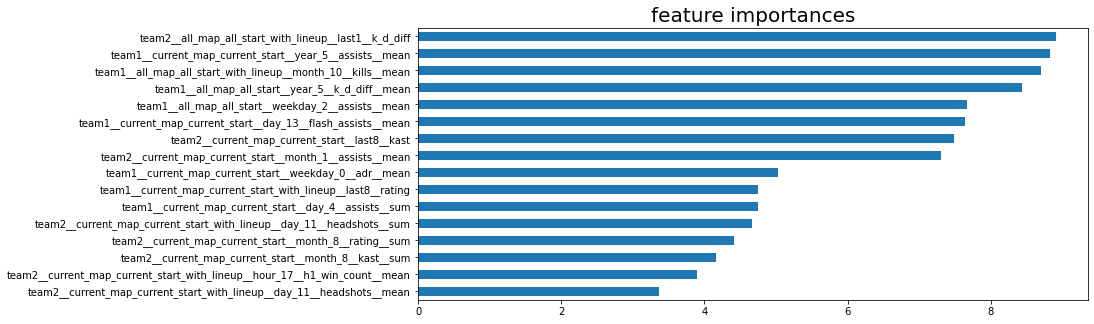

In [260]:
print('accuracy = {}'.format(best_acc))
pd.Series(dict(zip(_X.columns, model.feature_importances_))).sort_values(ascending = True).plot(kind = 'barh', figsize = (12, 5))
plt.title('feature importances', fontsize =20);

# Выводы:

1. для сокращения времени были использованы последние 1000 игр
2. произведен сплит данных, лейбл кодирование
3. признаки: перестановки p1, ..., p5, стата команд (стата команд с учетом состава игроков, стата на карте за сторону) в последних 10-ти играх, агрегирование стата команд (стата команд с учетом состава игроков, стата на карте за сторону)  по году, месяцу, дню, дню недели, часу
4. точность равна 67%
5. важность признаков

|признак|важность|
|---|---|
|team2__all_map_all_start_with_lineup__last1__k_d_diff|8.907196154838187|
|team1__current_map_current_start__year_5__assists__mean|8.820131888364132|
|team1__all_map_all_start_with_lineup__month_10__kills__mean|8.69707175159085|
|team1__all_map_all_start__year_5__k_d_diff__mean|8.441256457260296|
|team1__all_map_all_start__weekday_2__assists__mean|7.6737729351841715|
|team1__current_map_current_start__day_13__flash_assists__mean|7.636654934181761|
|team2__current_map_current_start__last8__kast|7.48309475811775|
|team2__current_map_current_start__month_1__assists__mean|7.30398224610863|
|team1__current_map_current_start__weekday_0__adr__mean|5.0323285921773735|
|team1__current_map_current_start_with_lineup__last8__rating|4.752622340682027|
|team1__current_map_current_start__day_4__assists__sum|4.7475373729430626|
|team2__current_map_current_start_with_lineup__day_11__headshots__sum|4.659018036140185|
|team2__current_map_current_start__month_8__rating__sum|4.4192178248673555|
|team2__current_map_current_start__month_8__kast__sum|4.168184484569796|
|team2__current_map_current_start_with_lineup__hour_17__h1_win_count__mean|3.8961251992475825|
|team2__current_map_current_start_with_lineup__day_11__headshots__mean|3.361805023726837|